**Carotid segmentation in ultrasound images**

from a dataset containing 1100 common carotid artery ultrasound images

dataset link:https://www.kaggle.com/datasets/orvile/carotid-ultrasound-images


In [1]:
import os
import numpy as np
import cv2
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten

**Dataset download**

In [2]:
import kagglehub

path = kagglehub.dataset_download("orvile/carotid-ultrasound-images")

print("Path to dataset files:", path)

100%|██████████| 284M/284M [00:01<00:00, 174MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/orvile/carotid-ultrasound-images/versions/2


**Data path**

In [3]:
img_dir= '/root/.cache/kagglehub/datasets/orvile/carotid-ultrasound-images/versions/2/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/US images'
msk_dir= '/root/.cache/kagglehub/datasets/orvile/carotid-ultrasound-images/versions/2/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images'

images= sorted(glob.glob(os.path.join(img_dir, '*.png')))
masks= sorted(glob.glob(os.path.join(msk_dir, '*.png')))

print(len(images))
print(len(masks))

1100
1100


**Data splitting**

In [4]:
import os
import random
import shutil

# Define paths
train_img_dir = "/kaggle/train/images"
train_mask_dir = "/kaggle/train/masks"
val_img_dir = "/kaggle/val/images"
val_mask_dir = "/kaggle/val/masks"
test_img_dir = "/kaggle/test/images"
test_mask_dir = "/kaggle/test/masks"

# Create directories if they don't exist
for dir_path in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, test_img_dir, test_mask_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Get all image names and filter only those that have corresponding masks
image_names = set(f for f in os.listdir(img_dir) if f.endswith((".png")))
mask_names = set(f for f in os.listdir(msk_dir) if f.endswith((".png")))

# Ensure only files that exist in both folders are used
valid_image_names = list(image_names.intersection(mask_names))
print(f'unique images and masks: {len(valid_image_names)}')

# Shuffle for randomness
random.seed(42)
random.shuffle(valid_image_names)

# Split the dataset
test_images = valid_image_names[:100]
train_images = valid_image_names[100:850]  # 750 images for training
val_images = valid_image_names[850:1100]   # 250 images for validation

# Function to move files
def move_files(image_list, src_img_dir, src_mask_dir, dest_img_dir, dest_mask_dir):
    for img in image_list:
        shutil.move(os.path.join(src_img_dir, img), os.path.join(dest_img_dir, img))
        shutil.move(os.path.join(src_mask_dir, img), os.path.join(dest_mask_dir, img))

# Move images and corresponding masks
move_files(test_images, img_dir, msk_dir, test_img_dir, test_mask_dir)
move_files(train_images, img_dir, msk_dir, train_img_dir, train_mask_dir)
move_files(val_images, img_dir, msk_dir, val_img_dir, val_mask_dir)

print("Dataset split completed successfully!")


unique images and masks: 1100
Dataset split completed successfully!


In [5]:
len(train_images)

750

**Showing some train images and their corresponding masks**


Paths exist!
/kaggle/train/images/202201121819140033VAS_slice_2022.png 
 /kaggle/train/masks/202201121819140033VAS_slice_2022.png
Paths exist!
/kaggle/train/images/202201121850550042VAS_slice_1640.png 
 /kaggle/train/masks/202201121850550042VAS_slice_1640.png
Paths exist!
/kaggle/train/images/202202071355210050VAS_slice_197.png 
 /kaggle/train/masks/202202071355210050VAS_slice_197.png
Paths exist!
/kaggle/train/images/202201121841080039VAS_slice_2319.png 
 /kaggle/train/masks/202201121841080039VAS_slice_2319.png
Paths exist!
/kaggle/train/images/202202071316520029VAS_slice_551.png 
 /kaggle/train/masks/202202071316520029VAS_slice_551.png
(749, 709, 3)
(749, 709)
(749, 709, 3)
(749, 709)
(749, 709, 3)
(749, 709)
(749, 709, 3)
(749, 709)
(749, 709, 3)
(749, 709)


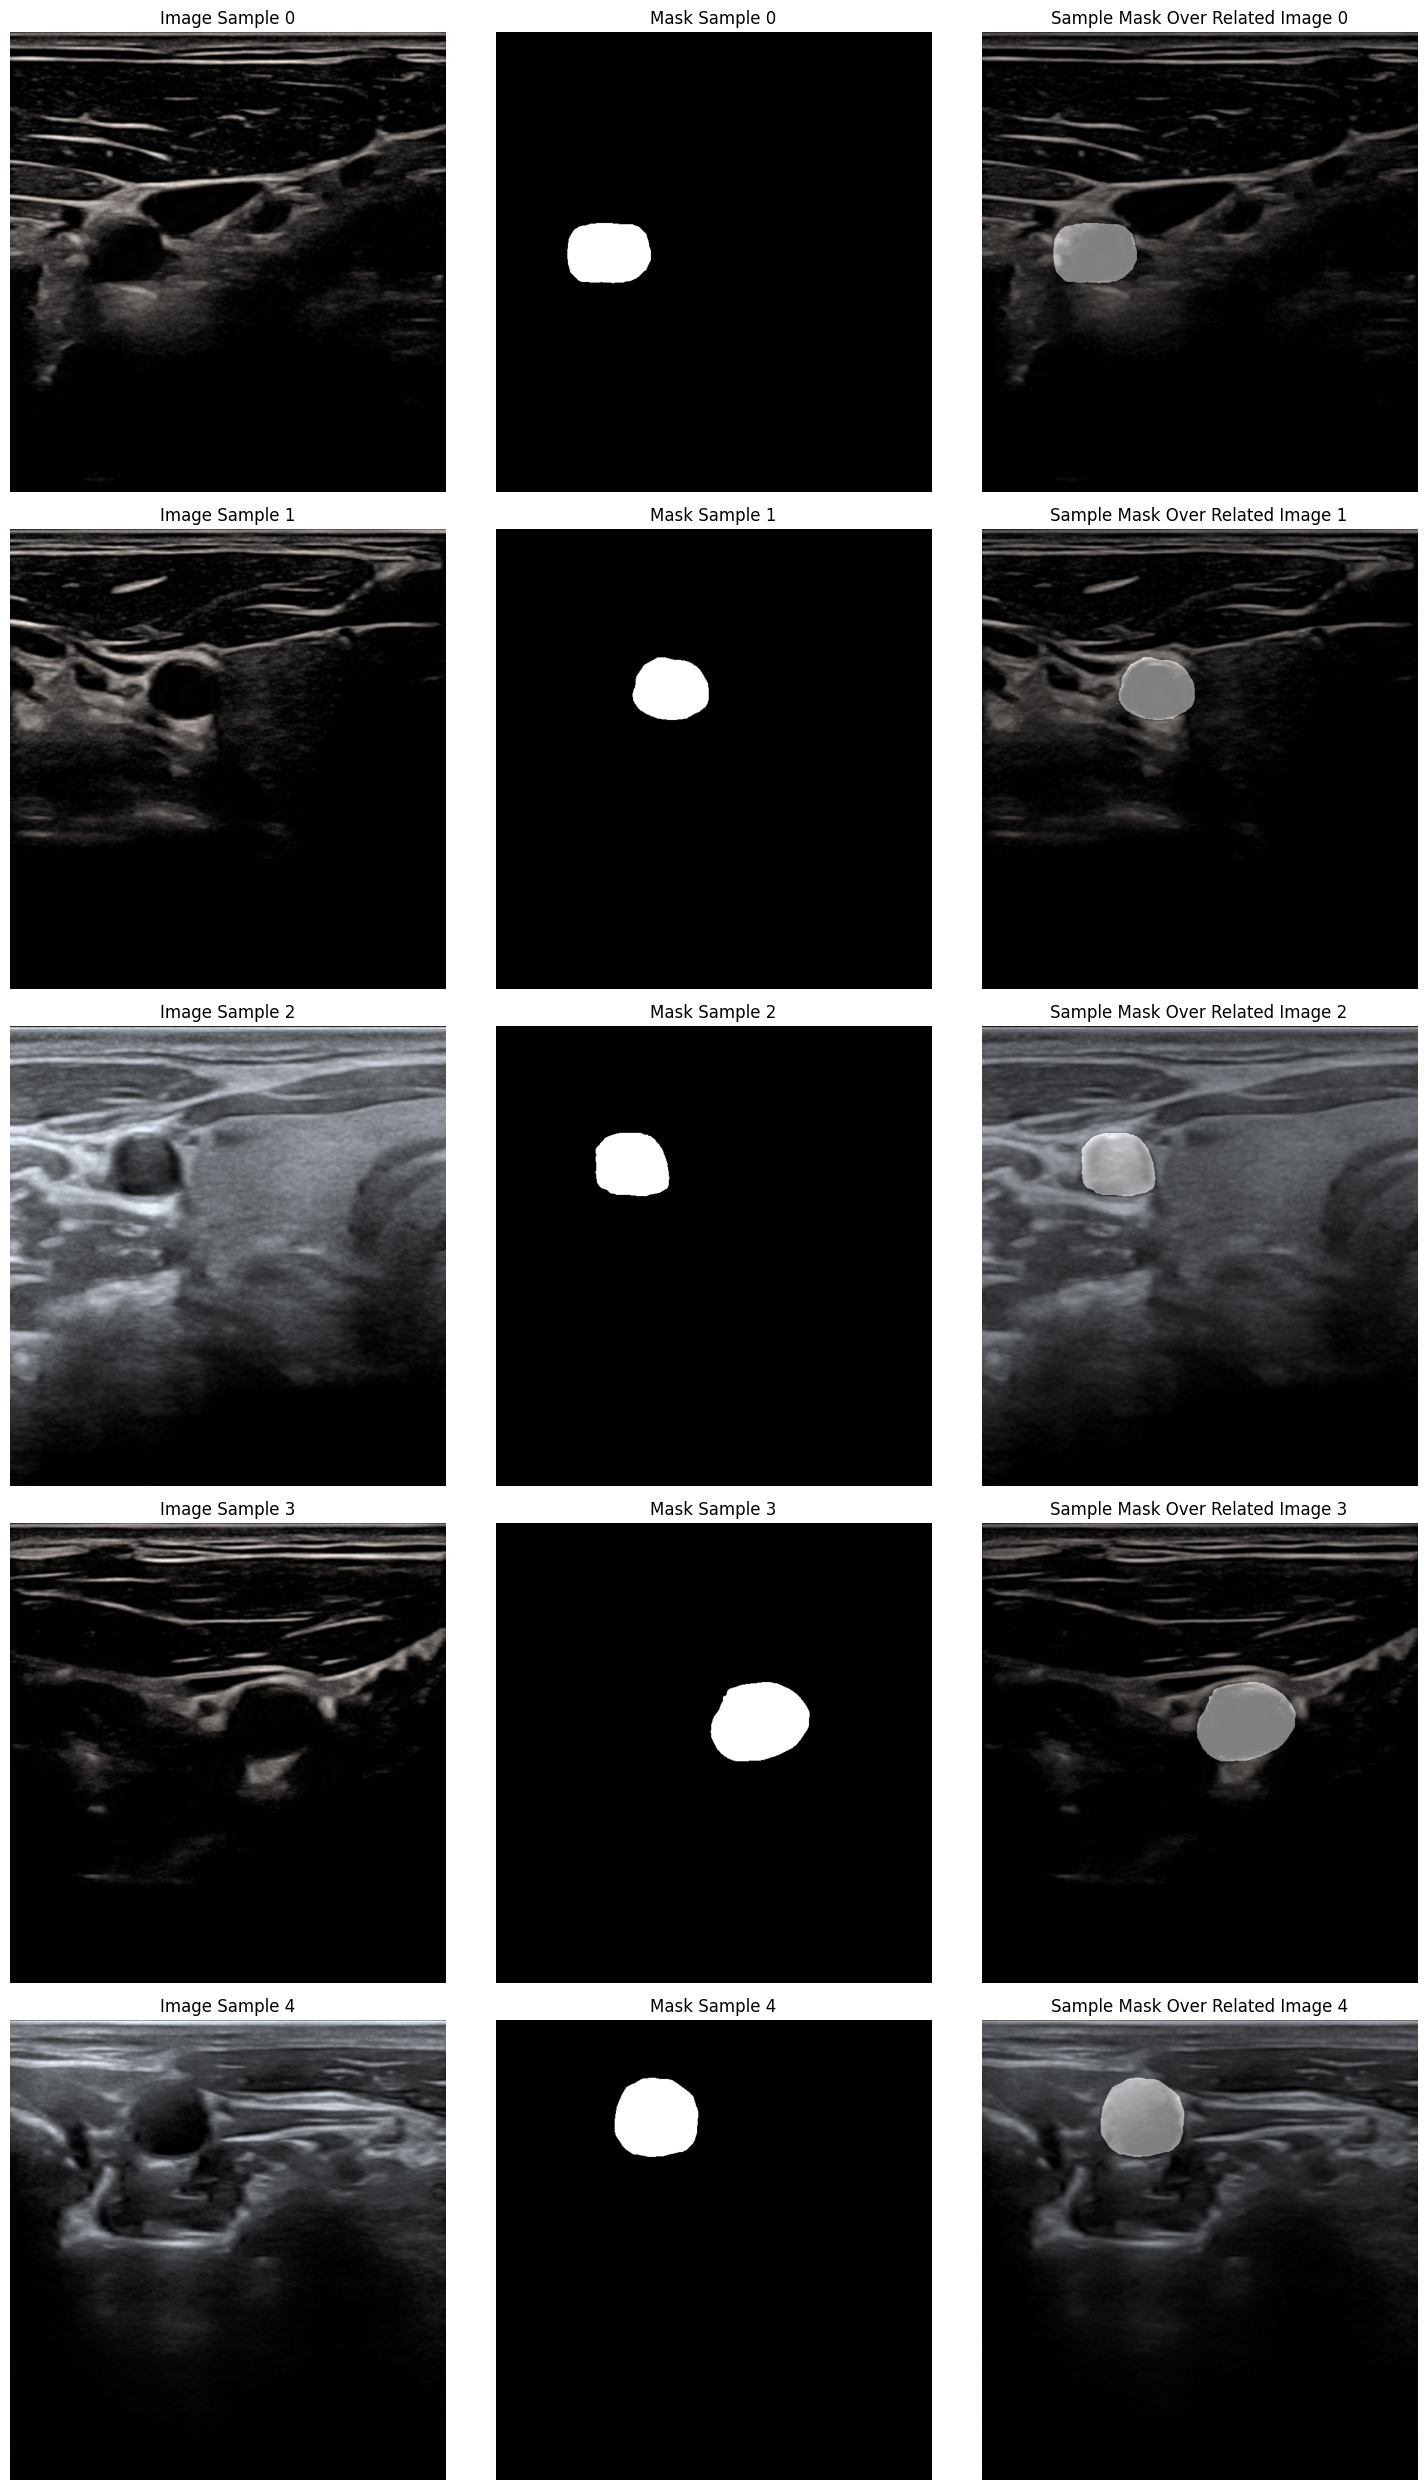

In [6]:
sam_num = 5
for sam in range(sam_num):
  images = []
  images_paths = []
  masks_paths = []
  images = random.sample(train_images , sam_num)
  for image in images:
    image_path = os.path.join(train_img_dir, image)
    mask_path = os.path.join(train_mask_dir , image)
    images_paths.append(image_path)
    masks_paths.append(mask_path)


# Check if paths exist
for impa , mapa in zip(images_paths , masks_paths):
  if os.path.exists(impa) and os.path.exists(mapa):
    print("Paths exist!")
    print(impa, "\n", mapa)
  else:
    print("One or both paths do not exist. Check your directory structure.")

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5 * sam_num))

for i, (image_path, mask_path) in enumerate(zip(images_paths, masks_paths)):

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    plt.subplot(sam_num, 3, 3 * i + 1)
    plt.title(f"Image Sample {i}")
    plt.imshow(image)
    print(image.shape)
    plt.axis("off")

    plt.subplot(sam_num, 3, 3 * i + 2)
    plt.title(f"Mask Sample {i}")
    plt.imshow(mask, cmap="gray")
    print(mask.shape)
    plt.axis("off")

    overlay = cv2.addWeighted(image, 0.7, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB), 0.5, 0)
    plt.subplot(sam_num, 3, 3 * i + 3)
    plt.title(f"Sample Mask Over Related Image {i}")
    plt.imshow(overlay)
    plt.axis("off")

plt.tight_layout()
plt.show()

**Resizing images**

In [7]:
import torch
import cv2
import numpy as np
import os
from skimage.transform import resize
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Function to resize images
def resize_image(image, target_height, target_width):
    return resize(image, (target_height, target_width), mode="constant", preserve_range=True)


def load_data(img_dir, mask_dir):
    img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith((".png", ".jpg", ".jpeg"))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])

    X_list, Y_list = [], []

    for img_path, mask_path in tqdm(zip(img_files, mask_files), total=len(img_files)):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Warning: Could not read {img_path} or {mask_path}")
            continue

        # Resize
        img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
        mask_resized = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True).reshape(IMG_HEIGHT, IMG_WIDTH, 1)

        # Normalize and append
        X_list.append(img_resized / 255.0)  # Normalize images
        Y_list.append(mask_resized > 0)  # Convert masks to binary (True for segmented regions)

    return np.array(X_list, dtype=np.float32), np.array(Y_list, dtype=np.float32)

# Load dataset
X_train, Y_train = load_data(train_img_dir, train_mask_dir)
X_val, Y_val = load_data(val_img_dir, val_mask_dir)




100%|██████████| 250/250 [00:22<00:00, 11.32it/s]


**Defining metrics for model training**


In [13]:
from tensorflow.keras.layers import Flatten
import tensorflow.keras.backend as K


def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 1) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1)
    return dice

<span style="font-size:24px">**The model architecture**</span>


In [18]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model


inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))  # Add `shape=`

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

initial_lr = 1e-4
optimizer = Adam(learning_rate=initial_lr)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[dice_coef])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │        448 │ lambda_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128, 128,  │          0 │ conv2d_38[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_18[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64, 64,    │          0 │ conv2d_40[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_19[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 32, 32,    │          0 │ conv2d_42[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 16, 16,    │          0 │ conv2d_44[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_21[0][0]

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

<span style="font-size:24px">**Model callbacks**</span>

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define model save path
model_path = "./nuclei_finder_unet_1.h5"

# Initialize callbacks
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,      # Reduce by half
                              patience=3,      # After 3 epochs with no improvement
                              verbose=1,
                              min_lr=1e-7)     # Don't go below this

callbacks = [checkpoint, reduce_lr]

In [11]:
print(f"Model Input Shape: {model.input_shape}")
print(f"X_train Shape: {X_train.shape}, Y_train Shape: {Y_train.shape}")

Model Input Shape: (None, 128, 128, 3)
X_train Shape: (750, 128, 128, 3), Y_train Shape: (750, 128, 128, 1)


<span style="font-size:24px">**Model training**</span>

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - dice_coef: 0.0636 - loss: 0.6832
Epoch 1: val_loss did not improve from 0.10877
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 303ms/step - dice_coef: 0.0635 - loss: 0.6822 - val_dice_coef: 0.0141 - val_loss: 0.2274 - learning_rate: 1.0000e-04
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.0120 - loss: 0.2502
Epoch 2: val_loss did not improve from 0.10877
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - dice_coef: 0.0121 - loss: 0.2497 - val_dice_coef: 0.0347 - val_loss: 0.1938 - learning_rate: 1.0000e-04
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.0391 - loss: 0.1598
Epoch 3: val_loss did not improve from 0.10877
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - dice_coef: 0.0398 - loss: 0.1593 - val_dice_coef: 0.1359 - val_loss: 0.1222 - learning_rate: 1.0000e-04
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.1458 - loss: 0.1061
Epoch 4: val_loss did not improve from 0.10877
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/st

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - dice_coef: 0.1853 - loss: 0.0930 - val_dice_coef: 0.1914 - val_loss: 0.1044 - learning_rate: 1.0000e-04
Epoch 10/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.2073 - loss: 0.0890
Epoch 10: val_loss did not improve from 0.10443
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - dice_coef: 0.2075 - loss: 0.0890 - val_dice_coef: 0.2124 - val_loss: 0.1111 - learning_rate: 1.0000e-04
Epoch 11/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.2349 - loss: 0.0862
Epoch 11: val_loss improved from 0.10443 to 0.08352, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - dice_coef: 0.2350 - loss: 0.0861 - val_dice_coef: 0.2400 - val_loss: 0.0835 - learning_rate: 1.0000e-04
Epoch 12/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.2548 - loss: 0.0817
Epoch 12: val_loss did not improve from 0.08352
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - dice_coef: 0.2549 - loss: 0.0817 - val_dice_coef: 0.2403 - val_loss: 0.0920 - learning_rate: 1.0000e-04
Epoch 13/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.2774 - loss: 0.0781
Epoch 13: val_loss did not improve from 0.08352
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - dice_coef: 0.2776 - loss: 0.0780 - val_dice_coef: 0.2225 - val_loss: 0.1102 - learning_rate: 1.0000e-04
Epoch 14/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.2832 - loss: 0.0797
Epoch 14: val_loss improved from 0.08352 to 0.07167, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - dice_coef: 0.2832 - loss: 0.0797 - val_dice_coef: 0.3016 - val_loss: 0.0717 - learning_rate: 1.0000e-04
Epoch 15/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.3318 - loss: 0.0689
Epoch 15: val_loss improved from 0.07167 to 0.06545, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - dice_coef: 0.3320 - loss: 0.0689 - val_dice_coef: 0.3352 - val_loss: 0.0655 - learning_rate: 1.0000e-04
Epoch 16/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.3684 - loss: 0.0649
Epoch 16: val_loss did not improve from 0.06545
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - dice_coef: 0.3686 - loss: 0.0649 - val_dice_coef: 0.3327 - val_loss: 0.0747 - learning_rate: 1.0000e-04
Epoch 17/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.3995 - loss: 0.0606
Epoch 17: val_loss improved from 0.06545 to 0.05451, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - dice_coef: 0.3999 - loss: 0.0605 - val_dice_coef: 0.4267 - val_loss: 0.0545 - learning_rate: 1.0000e-04
Epoch 18/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.4493 - loss: 0.0530
Epoch 18: val_loss improved from 0.05451 to 0.04795, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - dice_coef: 0.4494 - loss: 0.0530 - val_dice_coef: 0.4713 - val_loss: 0.0480 - learning_rate: 1.0000e-04
Epoch 19/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.4675 - loss: 0.0521
Epoch 19: val_loss improved from 0.04795 to 0.04445, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - dice_coef: 0.4679 - loss: 0.0520 - val_dice_coef: 0.5366 - val_loss: 0.0444 - learning_rate: 1.0000e-04
Epoch 20/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.5964 - loss: 0.0422
Epoch 20: val_loss improved from 0.04445 to 0.03985, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - dice_coef: 0.5972 - loss: 0.0422 - val_dice_coef: 0.6718 - val_loss: 0.0398 - learning_rate: 1.0000e-04
Epoch 21/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.7222 - loss: 0.0341
Epoch 21: val_loss improved from 0.03985 to 0.02901, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - dice_coef: 0.7222 - loss: 0.0340 - val_dice_coef: 0.7070 - val_loss: 0.0290 - learning_rate: 1.0000e-04
Epoch 22/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.7492 - loss: 0.0289
Epoch 22: val_loss improved from 0.02901 to 0.02709, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - dice_coef: 0.7492 - loss: 0.0289 - val_dice_coef: 0.7415 - val_loss: 0.0271 - learning_rate: 1.0000e-04
Epoch 23/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.7718 - loss: 0.0268
Epoch 23: val_loss improved from 0.02709 to 0.02338, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - dice_coef: 0.7718 - loss: 0.0268 - val_dice_coef: 0.7647 - val_loss: 0.0234 - learning_rate: 1.0000e-04
Epoch 24/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.7934 - loss: 0.0239
Epoch 24: val_loss improved from 0.02338 to 0.02010, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - dice_coef: 0.7935 - loss: 0.0239 - val_dice_coef: 0.8085 - val_loss: 0.0201 - learning_rate: 1.0000e-04
Epoch 25/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8066 - loss: 0.0224
Epoch 25: val_loss did not improve from 0.02010
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - dice_coef: 0.8067 - loss: 0.0224 - val_dice_coef: 0.8049 - val_loss: 0.0212 - learning_rate: 1.0000e-04
Epoch 26/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8176 - loss: 0.0214
Epoch 26: val_loss improved from 0.02010 to 0.01748, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - dice_coef: 0.8178 - loss: 0.0214 - val_dice_coef: 0.8404 - val_loss: 0.0175 - learning_rate: 1.0000e-04
Epoch 27/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8326 - loss: 0.0199
Epoch 27: val_loss improved from 0.01748 to 0.01647, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - dice_coef: 0.8326 - loss: 0.0199 - val_dice_coef: 0.8410 - val_loss: 0.0165 - learning_rate: 1.0000e-04
Epoch 28/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8427 - loss: 0.0179
Epoch 28: val_loss improved from 0.01647 to 0.01569, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - dice_coef: 0.8427 - loss: 0.0179 - val_dice_coef: 0.8530 - val_loss: 0.0157 - learning_rate: 1.0000e-04
Epoch 29/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8570 - loss: 0.0169
Epoch 29: val_loss improved from 0.01569 to 0.01472, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - dice_coef: 0.8570 - loss: 0.0169 - val_dice_coef: 0.8625 - val_loss: 0.0147 - learning_rate: 1.0000e-04
Epoch 30/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - dice_coef: 0.8626 - loss: 0.0159
Epoch 30: val_loss did not improve from 0.01472
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - dice_coef: 0.8625 - loss: 0.0159 - val_dice_coef: 0.8574 - val_loss: 0.0151 - learning_rate: 1.0000e-04
Epoch 31/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8706 - loss: 0.0147
Epoch 31: val_loss improved from 0.01472 to 0.01312, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - dice_coef: 0.8705 - loss: 0.0147 - val_dice_coef: 0.8732 - val_loss: 0.0131 - learning_rate: 1.0000e-04
Epoch 32/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - dice_coef: 0.8719 - loss: 0.0148
Epoch 32: val_loss improved from 0.01312 to 0.01236, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - dice_coef: 0.8719 - loss: 0.0148 - val_dice_coef: 0.8793 - val_loss: 0.0124 - learning_rate: 1.0000e-04
Epoch 33/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8773 - loss: 0.0139
Epoch 33: val_loss did not improve from 0.01236
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - dice_coef: 0.8773 - loss: 0.0139 - val_dice_coef: 0.8826 - val_loss: 0.0125 - learning_rate: 1.0000e-04
Epoch 34/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8850 - loss: 0.0131
Epoch 34: val_loss did not improve from 0.01236
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - dice_coef: 0.8850 - loss: 0.0131 - val_dice_coef: 0.8819 - val_loss: 0.0125 - learning_rate: 1.0000e-04
Epoch 35/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8758 - loss: 0.0140
Epoch 35: val_loss improved from 0.01236 to 0.01103, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - dice_coef: 0.8759 - loss: 0.0140 - val_dice_coef: 0.8938 - val_loss: 0.0110 - learning_rate: 1.0000e-04
Epoch 36/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8907 - loss: 0.0123
Epoch 36: val_loss improved from 0.01103 to 0.01102, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - dice_coef: 0.8907 - loss: 0.0123 - val_dice_coef: 0.8920 - val_loss: 0.0110 - learning_rate: 1.0000e-04
Epoch 37/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - dice_coef: 0.8948 - loss: 0.0117
Epoch 37: val_loss improved from 0.01102 to 0.01089, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - dice_coef: 0.8948 - loss: 0.0117 - val_dice_coef: 0.8942 - val_loss: 0.0109 - learning_rate: 1.0000e-04
Epoch 38/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.8940 - loss: 0.0117
Epoch 38: val_loss did not improve from 0.01089
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - dice_coef: 0.8940 - loss: 0.0117 - val_dice_coef: 0.8958 - val_loss: 0.0114 - learning_rate: 1.0000e-04
Epoch 39/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8958 - loss: 0.0118
Epoch 39: val_loss improved from 0.01089 to 0.01019, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - dice_coef: 0.8958 - loss: 0.0118 - val_dice_coef: 0.9005 - val_loss: 0.0102 - learning_rate: 1.0000e-04
Epoch 40/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coef: 0.8974 - loss: 0.0113
Epoch 40: val_loss did not improve from 0.01019
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - dice_coef: 0.8974 - loss: 0.0113 - val_dice_coef: 0.9010 - val_loss: 0.0102 - learning_rate: 1.0000e-04


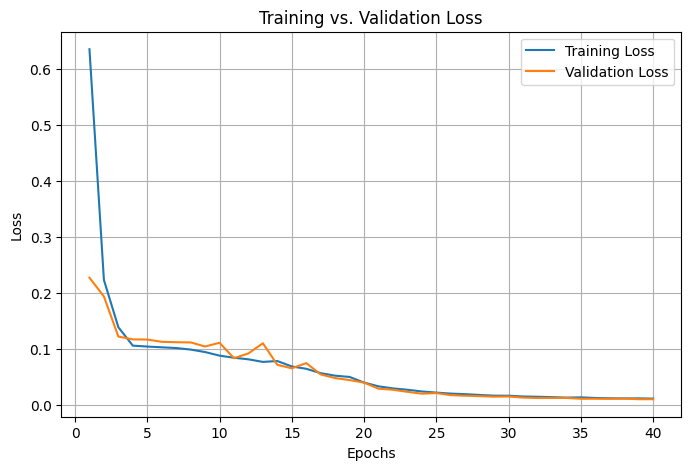

In [19]:
results = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=40,
                    batch_size=16,
                    callbacks=callbacks,
                    verbose=1)


import matplotlib.pyplot as plt

# Extract loss values from the training history
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


<span style="font-size:24px">**Model evaluation**</span>

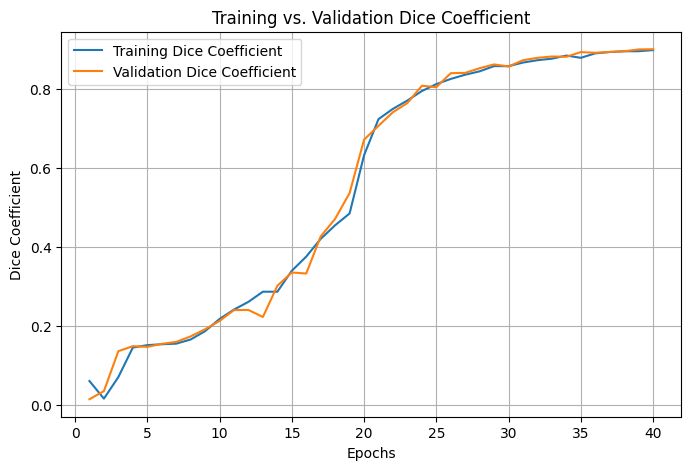

In [21]:
# Extract Dice Coefficient
dice = results.history['dice_coef']
val_dice = results.history['val_dice_coef']
epochs_range = range(1, len(dice) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, dice, label='Training Dice Coefficient')
plt.plot(epochs_range, val_dice, label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Training vs. Validation Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
final_train_dice = dice[-1]
final_val_dice = val_dice[-1]

print(f"Final Training Dice Coefficient: {final_train_dice:.4f}")
print(f"Final Validation Dice Coefficient: {final_val_dice:.4f}")


Final Training Dice Coefficient: 0.8988
Final Validation Dice Coefficient: 0.9010


<span style="font-size:">**Predicted mask for some test images with the trained model**</span>


100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 537ms/step


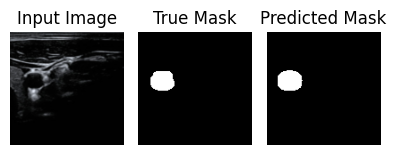

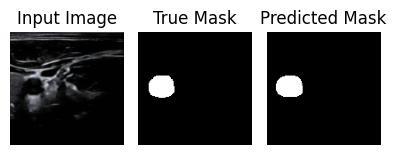

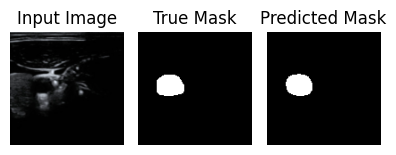

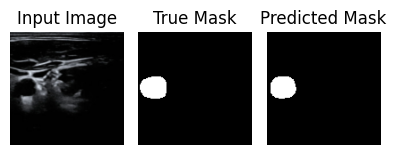

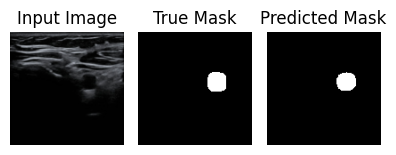

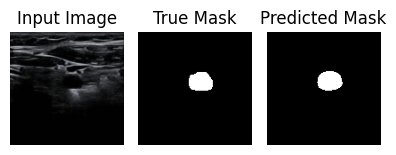

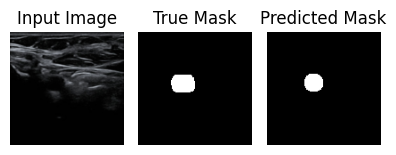

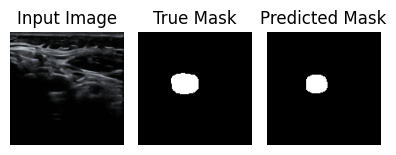

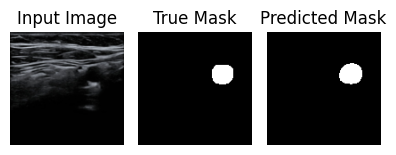

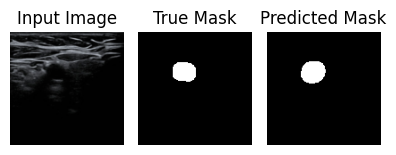

In [23]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

test_img_dir= '/kaggle/test/images'
test_mask_dir= '/kaggle/test/masks'
# Reuse your preprocessing function
X_test, Y_test = load_data(test_img_dir, test_mask_dir)

# Load your Keras model with custom dice metric
model = load_model(model_path, custom_objects={'dice_coef': dice_coef})

# Predict on test data
preds = model.predict(X_test)
preds_binary = (preds > 0.5).astype(np.uint8)

# Plot a few predictions
# Plot 10 predictions with smaller figure sizes
for i in range(min(10, len(X_test))):  # Visualize first 10 samples
    fig, axs = plt.subplots(1, 3, figsize=(4, 2))  # Smaller figure size
    axs[0].imshow(X_test[i])
    axs[0].set_title('Input Image')

    axs[1].imshow(Y_test[i].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')

    axs[2].imshow(preds_binary[i].squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

